# Обучить сиамскую сеть для верификации лиц на датасете LFW
Библиотеки: [Python, Tensorflow]

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers

from sklearn.manifold import TSNE

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Загрузка данных

In [48]:
(train_ds, test_ds), ds_info = tfds.load('lfw', 
                                         as_supervised=True, 
                                         with_info=True, 
                                         split=['train[:90%]', 
                                                'train[90%:]'],
                                         )

## Визуализация датасета

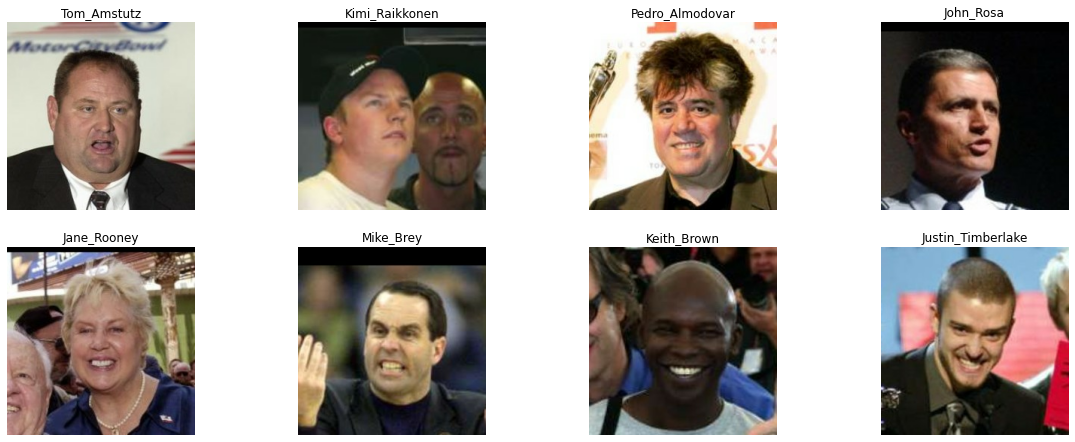

In [49]:
plt.figure(figsize=(20, 20))
for i, x in enumerate(train_ds.take(8)):
    plt.subplot(5, 4, i+1)
    plt.title(x[0].numpy().decode('utf-8'))
    plt.imshow(x[1])
    plt.axis('off')

## Создание модели CNN

In [50]:
EMB_SIZE = 64

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (5, 5), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(EMB_SIZE, activation=None),
])

## Contrastive Loss

In [51]:
MARGIN = 10.0

def contastive_loss(embs, labels):
    bs = embs.shape[0]
    embs1 = embs[:bs//2, :]
    embs2 = embs[bs//2:, :]
    labels1 = labels[:bs//2]
    labels2 = labels[bs//2:]

    d2 = tf.reduce_sum(tf.square(embs1 - embs2), axis=1)
    d =  tf.sqrt(d2)
    z = tf.cast(labels1 == labels2, tf.float32)
    
    return tf.reduce_mean(z * d2 + (1-z) * tf.maximum(0, MARGIN - d)**2)

## Подготовка пайплайна данных

In [52]:
INP_SIZE = 128
EPOCHS = 5
BATCH_SIZE = 64

def prepare_images(label, img):
    img = tf.cast(img, tf.float32) / 255.
    img = tf.image.resize(img, (INP_SIZE, INP_SIZE))
    return label, img

train_ds = train_ds.map(prepare_images)
train_ds = train_ds.repeat(EPOCHS)
train_ds = train_ds.batch(BATCH_SIZE)

test_ds = test_ds.map(prepare_images)
test_ds = test_ds.batch(BATCH_SIZE)

## Подготовка к обучению

In [53]:
LEARNING_RATE = 0.001
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)

## Обучение модели

In [54]:
%%time

labels_v, images_v = next(iter(test_ds))

train_loss = []
test_loss = []

for i, (labels, images) in enumerate(train_ds):
    # Forward
    with tf.GradientTape() as tape:
        embs = model(images)
        loss = contastive_loss(embs, labels)
    
    # Backward    
    grads = tape.gradient(loss, model.variables)
    optimizer.apply_gradients(zip(grads, model.variables))
    
    if i % 500 == 0:
        test_embs = model(images_v)
        val_loss = contastive_loss(test_embs, labels_v)
        
        train_loss.append(loss)
        test_loss.append(val_loss)
        
        print(f'[{i}]\t loss: {loss.numpy():.4f}\t| val_loss: {val_loss.numpy():.4f}')

[0]	 loss: 90.4503	| val_loss: 7.4558
[500]	 loss: 0.0458	| val_loss: 0.0070
Wall time: 57.7 s


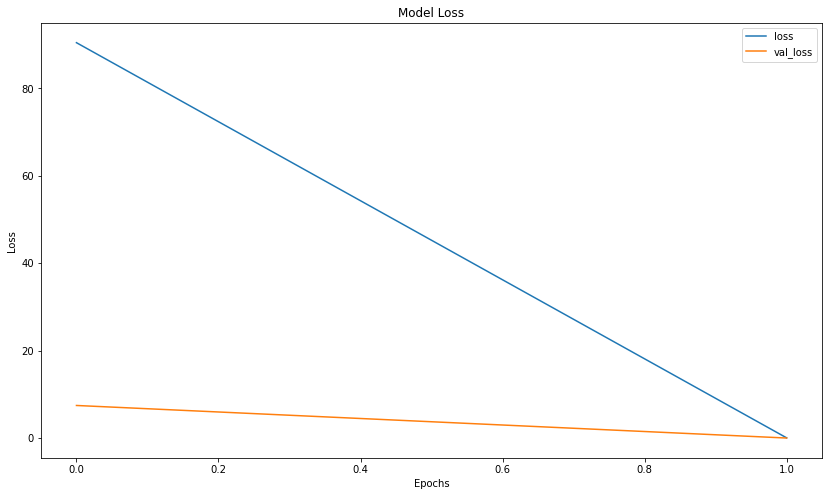

In [55]:
plt.figure(figsize=(14, 8))
plt.plot(train_loss, label='loss')
plt.plot(test_loss, label='val_loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.show()

## Тестирование

In [56]:
labels_v

<tf.Tensor: shape=(64,), dtype=string, numpy=
array([b'Francis_Collins', b'Jose_Luis_Santiago_Vasconcelos',
       b'Georgi_Parvanov', b'Donald_Rumsfeld', b'Kiki_Vandeweghe',
       b'Juan_Valencia_Osorio', b'Brian_StPierre', b'Jacques_Chirac',
       b'Silvio_Berlusconi', b'Andrew_Cuomo', b'Derek_Jeter',
       b'Colin_Powell', b'Gene_Orza', b'Adrien_Brody', b'Thomas_OBrien',
       b'Tiger_Woods', b'Steven_Tyler', b'Rolf_Eckrodt',
       b'Nicanor_Duarte_Frutos', b'Colin_Powell', b'Taha_Yassin_Ramadan',
       b'Michael_Douglas', b'Jefferson_Perez', b'Li_Zhaoxing',
       b'Camilla_Parker_Bowles', b'Princess_Hisako', b'Denise_Locke',
       b'Pierre_Png', b'Prince_Rainier_III', b'Jim_Taylor',
       b'Yashwant_Sinha', b'Carrie-Anne_Moss', b'Jamie_Villafane',
       b'Hamid_Karzai', b'Hugo_Chavez', b'Vladimir_Putin',
       b'Gene_Robinson', b'Alvaro_Uribe', b'George_W_Bush',
       b'Anna_Kournikova', b'Andrew_Sabey', b'Ariel_Sharon', b'Ernie_Els',
       b'Tony_Blair', b'Sadie_Frost

In [57]:
test_embs = model(images_v)
test_embs_2D = TSNE(n_components=2).fit_transform(test_embs)

In [58]:
def diff(e1, e2):
    return np.sum((e1 - e2)**2) ** 0.5

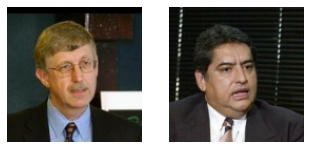

In [61]:
plt.figure(figsize=(14, 14))
plt.subplot(1, 5, 1)
plt.imshow(images_v[0])
plt.axis('off')
plt.subplot(1, 5, 2)
plt.imshow(images_v[1])
plt.axis('off')
plt.show()

In [60]:
Francis_Collins = test_embs_2D[0]
Jose_Luis_Santiago_Vasconcelos = test_embs_2D[1] 
print('Francis_Collins - Francis_Collins: '
      , diff(Francis_Collins, Francis_Collins))
print('Francis_Collins - Jose_Luis_Santiago_Vasconcelos: '
      , diff(Francis_Collins, Jose_Luis_Santiago_Vasconcelos))

Francis_Collins - Francis_Collins:  0.0
Francis_Collins - Jose_Luis_Santiago_Vasconcelos:  94.35327254029136


## Тестируем на картинках из интернета

In [84]:
def load_and_prepare_image(path_to_file):
    import imageio
    from skimage.transform import resize
    img = imageio.imread(path_to_file, pilmode='RGB')
    img = img.astype(np.float32) / 255.
    img = resize(img, (INP_SIZE, INP_SIZE), order=3, mode='reflect', anti_aliasing=True)
    return img

img_1 = load_and_prepare_image('Francis_Collins.jpg')
img_2 = load_and_prepare_image('Francis_Collins_3.jpg')
img_3 = load_and_prepare_image('Francis_Collins_4.jpg')

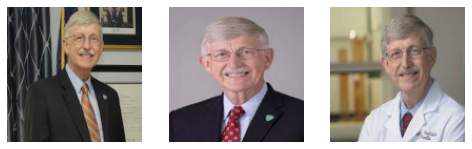

In [89]:
fig = plt.figure(figsize=(14, 12))
ax = fig.add_subplot(1, 5, 1)
ax.imshow(img_1)
plt.axis('off')
ax = fig.add_subplot(1, 5, 2)
ax.imshow(img_2)
plt.axis('off')
ax = fig.add_subplot(1, 5, 3)
ax.imshow(img_3)
plt.axis('off')
plt.show()

In [90]:
new_embs = model(np.stack((img_1, img_2, img_3), axis=0))

In [92]:
Francis_Collins_2 = new_embs[0,:]
Francis_Collins_3 = new_embs[1,:]
Francis_Collins_4 = new_embs[2,:]

print('Francis_Collins_2 <-> Francis_Collins_3: ', diff(Francis_Collins_2, Francis_Collins_3))
print('Francis_Collins_2 <-> Francis_Collins_4: ', diff(Francis_Collins_2, Francis_Collins_4))
print('Francis_Collins_3 <-> Francis_Collins_4: ', diff(Francis_Collins_3, Francis_Collins_4))

Francis_Collins_2 <-> Francis_Collins_3:  16.526002682089747
Francis_Collins_2 <-> Francis_Collins_4:  15.935279601761875
Francis_Collins_3 <-> Francis_Collins_4:  16.8800547623311
